In [7]:
from tensorflow.python.client import device_lib
import tensorflow as tf
from skill_label_classifier import *
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from gensim.test.utils import datapath
from gensim.models import KeyedVectors

In [2]:
experiment = SkillClassifier()
experiment.import_data()
experiment.create_df()

experiment.choose_dataset('vqa')
experiment.set_features(['QSN', 'descriptions', 'tags', 'dominant_colors','handwritten_text', 'ocr_text'])
experiment.set_targets()

features_train = experiment.features_train
features_val   = experiment.features_val

# check training class distribution
text_recognition_y_train = to_categorical(np.asarray(experiment.txt_train)).astype('float32')
color_recognition_y_train = to_categorical(np.asarray(experiment.col_train)).astype('float32')
print('Number of training samples each class: ')
print('Text recognition', text_recognition_y_train.sum(axis=0))
print('Color recognition', color_recognition_y_train.sum(axis=0))

# multilabel
n_classes = 4

# combine training labels
y_train = np.column_stack((text_recognition_y_train, color_recognition_y_train))

# check validation class distribution
text_recognition_y_val = to_categorical(np.asarray(experiment.txt_val)).astype('float32')
color_recognition_y_val = to_categorical(np.asarray(experiment.col_val)).astype('float32')
print('Number of validation samples each class: ')
print('Text recognition', text_recognition_y_val.sum(axis=0))
print('Color recognition', color_recognition_y_val.sum(axis=0))

# combine validation labels
y_val = np.column_stack((text_recognition_y_val, color_recognition_y_val))

Joined features with skill labels.
Joined features with skill labels.
Joined features with skill labels.
Joined features with skill labels.
VizWiz training shape: (14257, 13)
VQA training shape: (3230, 13)
Total training rows: 17487
VizWiz validation shape:(2247, 13)
VQA validation shape:(513, 13)
Total validation rows: 2760
Training: (3230, 13)
Validation: (513, 13)
Number of training samples each class: 
Text recognition [2872.  358.]
Color recognition [2082. 1148.]
Number of validation samples each class: 
Text recognition [450.  63.]
Color recognition [334. 179.]


In [8]:
# tokenize
tok        = Tokenizer(num_words=VOCAB_SIZE, 
                       filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                       lower=True,
                       split=" ")
tok.fit_on_texts(features_train)

# create sequences & pad
train_seq  = tok.texts_to_sequences(features_train)
train_seq  = sequence.pad_sequences(train_seq, maxlen=MAX_DOC_LEN)
val_seq    = tok.texts_to_sequences(features_val)
val_seq    = sequence.pad_sequences(val_seq, maxlen=MAX_DOC_LEN)

# standardize training and testing features
sc = StandardScaler()
train_seq = sc.fit_transform(train_seq)
val_seq = sc.transform(val_seq)

# Set validation tuple - text recognition
val_data = (val_seq, text_recognition_y_val)

# punkt sentence level tokenizer
sent_lst = [] 
for doc in features_train:
    sentences = nltk.tokenize.sent_tokenize(doc)
    for sent in sentences:
        word_lst = [w for w in nltk.tokenize.word_tokenize(sent) if w.isalnum()]
        sent_lst.append(word_lst)

EMBEDDING_DIM = 300
googlenews_corpus = '/anaconda/envs/py35/lib/python3.5/site-packages/gensim/test/test_data/GoogleNews-vectors-negative300.bin'
# Intersect with pre-trained word2vec on GoogleNews (https://code.google.com/archive/p/word2vec/)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
word2vec_model = KeyedVectors.load_word2vec_format(datapath(googlenews_corpus), binary=True)

#word2vec_model = gensim.models.Word2Vec(sentences=sent_lst,
#                                        workers=os.cpu_count(),         # parallel requires Cython
#                                        size=EMBEDDING_DIM)
#word2vec_model.intersect_word2vec_format(googlenews_corpus, lockf=1.0, binary=True)
#word2vec_model.train(sentences=sent_lst,
#                total_examples=w2v_model.corpus_count,
#                epochs=word2vec_model.iter)

embeddings_index = {}
for word in word2vec_model.wv.vocab:
    coefs = np.asarray(word2vec_model.wv[word], dtype='float32')
    embeddings_index[word] = coefs
print('Total %s word vectors' % len(embeddings_index))

# Initial word embedding
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

for word, i in tok.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None and i < VOCAB_SIZE:
        embedding_matrix[i] = embedding_vector

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
2019-03-19 20:23:49,488 : INFO : loading projection weights from /anaconda/envs/py35/lib/python3.5/site-packages/gensim/test/test_data/GoogleNews-vectors-negative300.bin
2019-03-19 20:24:35,239 : INFO : loaded (3000000, 300) matrix from /anaconda/envs/py35/lib/python3.5/site-packages/gensim/test/test_data/GoogleNews-vectors-negative300.bin
/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:45: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:46: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


Total 3000000 word vectors


In [9]:
# helper function to find optimal number of PC (elbow method)
def plot_explained_variance(X_train):
    pca = PCA()
    pca_full = pca.fit(X_train)
    plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
    plt.xlabel("number of principal components")
    plt.ylabel("cumulative explained variance")
    plt.grid(color='grey',linestyle='-',alpha=0.2)
    plt.show()
    
def preprocess_pca(X_train, X_test, dim, r=None):
    pca = PCA(n_components=dim, random_state=r)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca

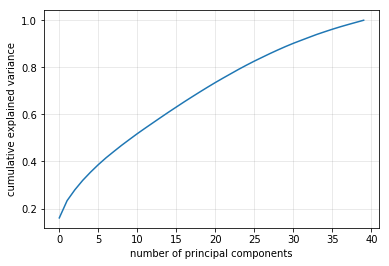

In [10]:
plot_explained_variance(train_seq)

In [11]:
train_seq, val_seq = preprocess_pca(train_seq, val_seq, dim=40)

## VQA text recogintion, all features, 500 epochs (without PCA)

In [8]:
# all feature, VQA text
L = 1e-2
R = 0
B = 32
E = 500
skill='text'
vqa_text_result = lstm_create_train(train_seq, embedding_matrix,
                 train_labels=text_recognition_y_train, skill=skill,
                 val_data=val_data,
                 learning_rate=L,
                 lstm_dim=100,
                 batch_size=B,
                 num_epochs=E,
                 optimizer_param=SGD(lr=L, nesterov=True),
                 regularization=R)
model = load_model('./LSTM/{}/{}_{}_{}_{}_model.h5'.format(skill,L,R,B,E))
preds = model.predict(val_seq, verbose=0)
print("Learning rate: {} Regularization: {} Batch size: {} Epoch: {}".format(L,R,B,E))
print(("Accuracy = {0} \t AUC = {1}".format(accuracy_score(txt_val, preds.argmax(axis=1)), 
                                                            roc_auc_score(txt_val, preds[:,1]))))

Learning rate: 0.01 Regularization: 0 Batch size: 32 Epoch: 500
Accuracy = 0.8713450292397661 	 AUC = 0.7552380952380953


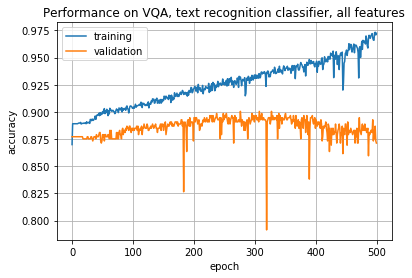

In [10]:
plt.plot([i for i in range(500)], vqa_text_result['acc'],label='training')
plt.plot([i for i in range(500)], vqa_text_result['val_acc'],label='validation')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Performance on VQA, text recognition classifier, all features")
plt.grid()
plt.legend()
plt.show()

## Vizwiz text recognition, all features (without PCA)

In [6]:
L = 1e-2
R = 0
B = 32
E = 500
skill='text'
vizwiz_text_result = lstm_create_train(train_seq, embedding_matrix,
                 train_labels=text_recognition_y_train, skill=skill,
                 val_data=val_data,
                 learning_rate=L,
                 lstm_dim=100,
                 batch_size=B,
                 num_epochs=E,
                 optimizer_param=SGD(lr=L, nesterov=True),
                 regularization=R)
model = load_model('./LSTM/{}/{}_{}_{}_{}_model.h5'.format(skill,L,R,B,E))
preds = model.predict(val_seq, verbose=0)
print("Learning rate: {} Regularization: {} Batch size: {} Epoch: {}".format(L,R,B,E))
print(("Accuracy = {0} \t AUC = {1}".format(accuracy_score(txt_val, preds.argmax(axis=1)), 
                                                            roc_auc_score(txt_val, preds[:,1]))))

Learning rate: 0.01 Regularization: 0 Batch size: 32 Epoch: 500
Accuracy = 0.8170894526034713 	 AUC = 0.8729808046494495


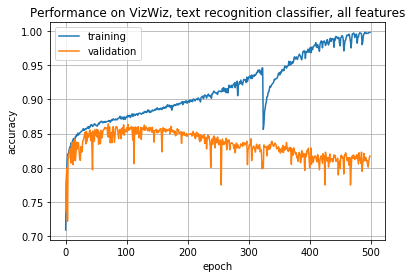

In [13]:
plt.plot([i for i in range(500)], vizwiz_text_result['acc'],label='training')
plt.plot([i for i in range(500)], vizwiz_text_result['val_acc'],label='validation')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Performance on VizWiz, text recognition classifier, all features")
plt.grid()
plt.legend()
plt.show()

In [26]:
max(vizwiz_text_result['val_acc'])

0.8642634624738825

## VQA - full feature, 40 PC

In [16]:
L = 1e-2
R = 0
B = 32
E = 10
skill='text'
vizwiz_result_500 = lstm_create_train(train_seq, embedding_matrix,
                 train_labels=text_recognition_y_train, skill=skill,
                 val_data=val_data,
                 learning_rate=L,
                 lstm_dim=100,
                 batch_size=B,
                 num_epochs=E,
                 optimizer_param=SGD(lr=L, nesterov=True),
                 regularization=R)
model = load_model('./LSTM/{}/{}_{}_{}_{}_model.h5'.format(skill,L,R,B,E))
preds = model.predict(val_seq, verbose=0)
print("Learning rate: {} Regularization: {} Batch size: {} Epoch: {}".format(L,R,B,E))
print(("Accuracy = {0} \t AUC = {1}".format(accuracy_score(txt_val, preds.argmax(axis=1)), 
                                                            roc_auc_score(txt_val, preds[:,1]))))

Learning rate: 0.01 Regularization: 0 Batch size: 32 Epoch: 10
Accuracy = 0.6110369381397419 	 AUC = 0.6644558588793845


## VQA, full feature, 40 PC

In [12]:
# change: stack LSTM layers 
L = 0.01
R = 1e-13
B = 64
E = 1000
skill='text'
vqa_results = lstm_create_train(train_seq, embedding_matrix,
                 train_labels=text_recognition_y_train, skill=skill,
                 val_data=val_data,
                 learning_rate=L,
                 lstm_dim=100,
                 batch_size=B,
                 num_epochs=E,
                 optimizer_param=SGD(lr=L, nesterov=True),
                 regularization=R)
model = load_model('./LSTM/{}/{}_{}_{}_{}_model.h5'.format(skill,L,R,B,E))
preds = model.predict(val_seq, verbose=0)
print("Learning rate: {} Regularization: {} Batch size: {} Epoch: {}".format(L,R,B,len(vqa_results.history['acc'])))
print(("Accuracy = {0} \t AUC = {1}".format(accuracy_score(txt_val, preds.argmax(axis=1)), 
                                                            roc_auc_score(txt_val, preds[:,1]))))

Learning rate: 0.01 Regularization: 1e-13 Batch size: 64 Epoch: 1000
Accuracy = 0.8771929824561403 	 AUC = 0.5721516754850089


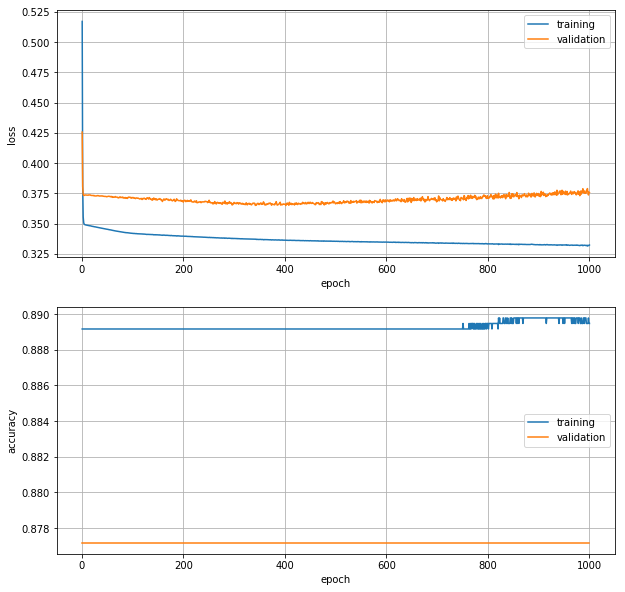

In [15]:
# result with exponential learning scheduler
fig = plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot([i for i in range(1,1001)], vqa_results.history['loss'],label='training')
plt.plot([i for i in range(1,1001)], vqa_results.history['val_loss'],label='validation')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.legend()

plt.subplot(2,1,2)
plt.plot([i for i in range(1,1001)], vqa_results.history['acc'],label='training')
plt.plot([i for i in range(1,1001)], vqa_results.history['val_acc'],label='validation')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid()
plt.legend()

plt.show()

In [16]:
%store vqa_results

Stored 'vqa_results' (History)


## VQA with google news corpus


In [12]:
L = 0.01
R = 1e-13
B = 32
E = 100
skill='text'
vqa_results = lstm_create_train(train_seq, embedding_matrix,
                 train_labels=text_recognition_y_train, skill=skill,
                 val_data=val_data,
                 learning_rate=L,
                 lstm_dim=100,
                 batch_size=B,
                 num_epochs=E,
                 optimizer_param=SGD(lr=L, nesterov=True),
                 regularization=R)
model = load_model('./LSTM/{}/{}_{}_{}_{}_model.h5'.format(skill,L,R,B,E))
preds = model.predict(val_seq, verbose=0)
print("Learning rate: {} Regularization: {} Batch size: {} Epoch: {}".format(L,R,B,len(vqa_results.history['acc'])))
print(("Accuracy = {0} \t AUC = {1}".format(accuracy_score(txt_val, preds.argmax(axis=1)), 
                                                            roc_auc_score(txt_val, preds[:,1]))))

ValueError: Error when checking target: expected dense_1 to have shape (4,) but got array with shape (2,)

### Vizwiz text recognition, all features (40 PC)

In [8]:
L = 1e-1
R = 0
B = 32
E = 1000
skill='text'
vizwiz_text_result = lstm_create_train(train_seq, embedding_matrix,
                 train_labels=text_recognition_y_train, skill=skill,
                 val_data=val_data,
                 learning_rate=L,
                 lstm_dim=100,
                 batch_size=B,
                 num_epochs=E,
                 optimizer_param=SGD(lr=L, nesterov=True),
                 regularization=R)
model = load_model('./LSTM/{}/{}_{}_{}_{}_model.h5'.format(skill,L,R,B,E))
preds = model.predict(val_seq, verbose=0)
print("Learning rate: {} Regularization: {} Batch size: {} Epoch: {}".format(L,R,B,E))
print(("Accuracy = {0} \t AUC = {1}".format(accuracy_score(txt_val, preds.argmax(axis=1)), 
                                                            roc_auc_score(txt_val, preds[:,1]))))

KeyboardInterrupt: 